In [71]:
from collections import defaultdict, OrderedDict
import datetime
import json
import os

import numpy as np


CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, "data")
GROUP_JSON = "pyladies_group.json"
MEMBERS_JSON = "pyladies_members.json"
PUG_MEMBERS_JSON = "{user_group}.json"
IGNORE_JSON = [GROUP_JSON, MEMBERS_JSON]
GROUP_DIRS = [d for d in os.listdir(DATA_DIR)]
PYLADIES_GROUPS = []
for group in GROUP_DIRS:
    if os.path.isdir(os.path.join(DATA_DIR, group)):
        PYLADIES_GROUPS.append(group)

In [2]:
# load group data for a PyLadies Meetup Group
def load_group_data(pyladies_group):
    pyladies_dir = os.path.join(DATA_DIR, pyladies_group)

    # don't load files to ignore
    groups = os.listdir(pyladies_dir)
    for group in IGNORE_JSON:
        try:
            group_index = groups.index(group)
            groups.pop(group_index)
        except ValueError:
            pass
    group_data = []
    for group in groups:
        group_file = os.path.join(pyladies_dir, group)
        with open(group_file, "r") as f:
            data = json.load(f)
        group_name = group.strip(".json")
        tmp = dict(name=group_name, data=data)
        group_data.append(tmp)
    return group_data

In [3]:
def pyladies_created(pyladies_group):
    pyladies_dir = os.path.join(DATA_DIR, pyladies_group)
    pyladies_file = os.path.join(pyladies_dir, "pyladies_group.json")
    with open(pyladies_file, "r") as f:
        data = json.load(f)
    created_ms = data.get("created")
    created_s = created_ms / 1000
    created = datetime.datetime.fromtimestamp(created_s)
    year = created.strftime("%Y")
    month = created.strftime("%m")
    day = created.strftime("%d")
    return year, month, day

In [4]:
def get_member_joined(group_member_data):
    joined = [g.get("joined") for g in group_member_data]
    ret = []
    for j in joined:
        if j:  # May be 'None':
            ms = int(j) / 1000
            dt = datetime.datetime.fromtimestamp(ms)
            ret.append(dt)
    return ret

In [105]:
def create_buckets(joined_data):
    buckets = {}
    for member in joined_data:
        # get month & year
        year = member.strftime("%Y")
        month = member.strftime("%m")
        key = "{0}-{1}".format(year, month)
        if not buckets.get(key):
            buckets[key] = 1
        else:
            buckets[key] += 1
    return buckets

In [405]:
def create_null_data(group_data):
    buckets = []
    min_start_date = datetime.datetime.today()
    for group in group_data:
        data = group.get("data")
        if not data:
            return group_data
        start_date = datetime.datetime.strptime(sorted(list(data.keys()))[0], "%Y-%m")
        if start_date < min_start_date:
            min_start_date = start_date
            buckets = list(data.keys())
    
    ordered_buckets = sorted(buckets)
    for group in group_data:
        ordered_data = OrderedDict()
        for b in ordered_buckets:
            if b not in group["data"]:
                ordered_data[b] = 0
            else:
                ordered_data[b] = group["data"][b]
                group["data"][b] = 0
        group["data"] = ordered_data

    return group_data
    

In [106]:
def get_member_joined_groups(groups):
    ret = []
    for group in groups:
        joined = get_member_joined(group.get("data"))
        buckets = create_buckets(joined)
        tmp = dict(name=group.get("name"), data=buckets)
        ret.append(tmp)
    return ret

In [7]:
%matplotlib inline

In [224]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [1]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                  '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']
pylady_magenta = '#c62d3a'

def generate_plot(data, created):
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    
    # Remove the plot frame lines. They are unnecessary here.
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # Remove the tick marks just for more pleasant visuals
    plt.tick_params(axis='both', which='both', bottom='off', top='off',
                    labelbottom='on', left='off', right='off', labelleft='on')
    
    max_joined = 0
    created_x_axis = 0
    for i, group in enumerate(data):
        data = group.get("data")
        if not data:
            continue
        joined = np.array(list(data.values()))
        buckets = np.array(list(data.keys()))
        total = len(data.keys())
        if created in list(data.keys()):
            created_x_axis = list(data.keys()).index(created)
        max_joined = max(max_joined, max(list(data.values())))

        plt.plot(range(total), joined, lw=2.5, color=color_sequence[i], label=group.get("name"))

        # only label every 6 months
        x_labels = []
        for i,b in enumerate(buckets):
            if i % 6 == 0:
                x_labels.append(b)
            else:
                x_labels.append(" ")
        plt.xticks(range(total), x_labels, rotation=90)

    plt.axvline(x=created_x_axis, linewidth=6, color=pylady_magenta)
    
    created_y_arrow = int(round(max_joined * .80))
    created_y_label = int(round(created_y_arrow * .80))
    created_split = created.split("-")
    month, year = created_split
    plt.annotate("PyLadies started\n{0}-{1}".format(year, month),
                 color=pylady_magenta,
                 fontsize=20,
                 xy=(created_x_axis, created_y_arrow),
                 xytext=(created_x_axis - 20, created_y_label), 
                 xycoords="data",
                 arrowprops=dict(arrowstyle="->", color=pylady_magenta, linewidth=3))
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
               fontsize=20,
               loc=3, 
               ncol=2, 
               mode="expand", 
               borderaxespad=0.)
    plt.show()

In [394]:
def create_graph(pylady_group):
    year, month, _ = pyladies_created(pylady_group)
    created = "{0}-{1}".format(year, month)
    group_data = load_group_data(pylady_group)
    joined_data = get_member_joined_groups(group_data)
    joined_data = create_null_data(joined_data)
    generate_plot(joined_data, created)

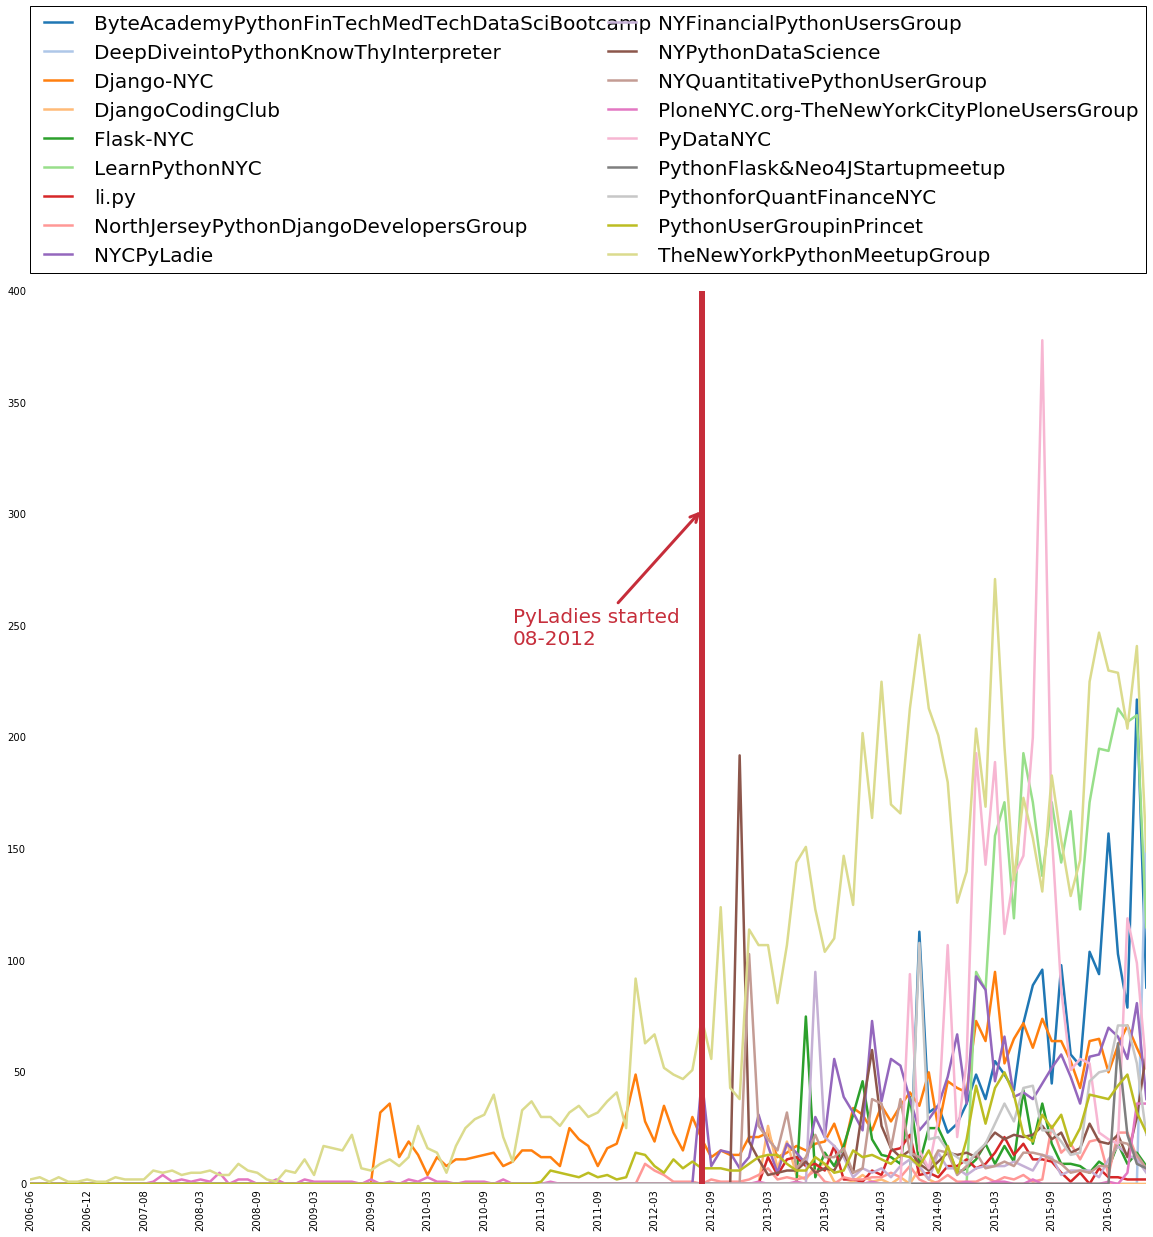

In [395]:
create_graph("NYCPyLadies")

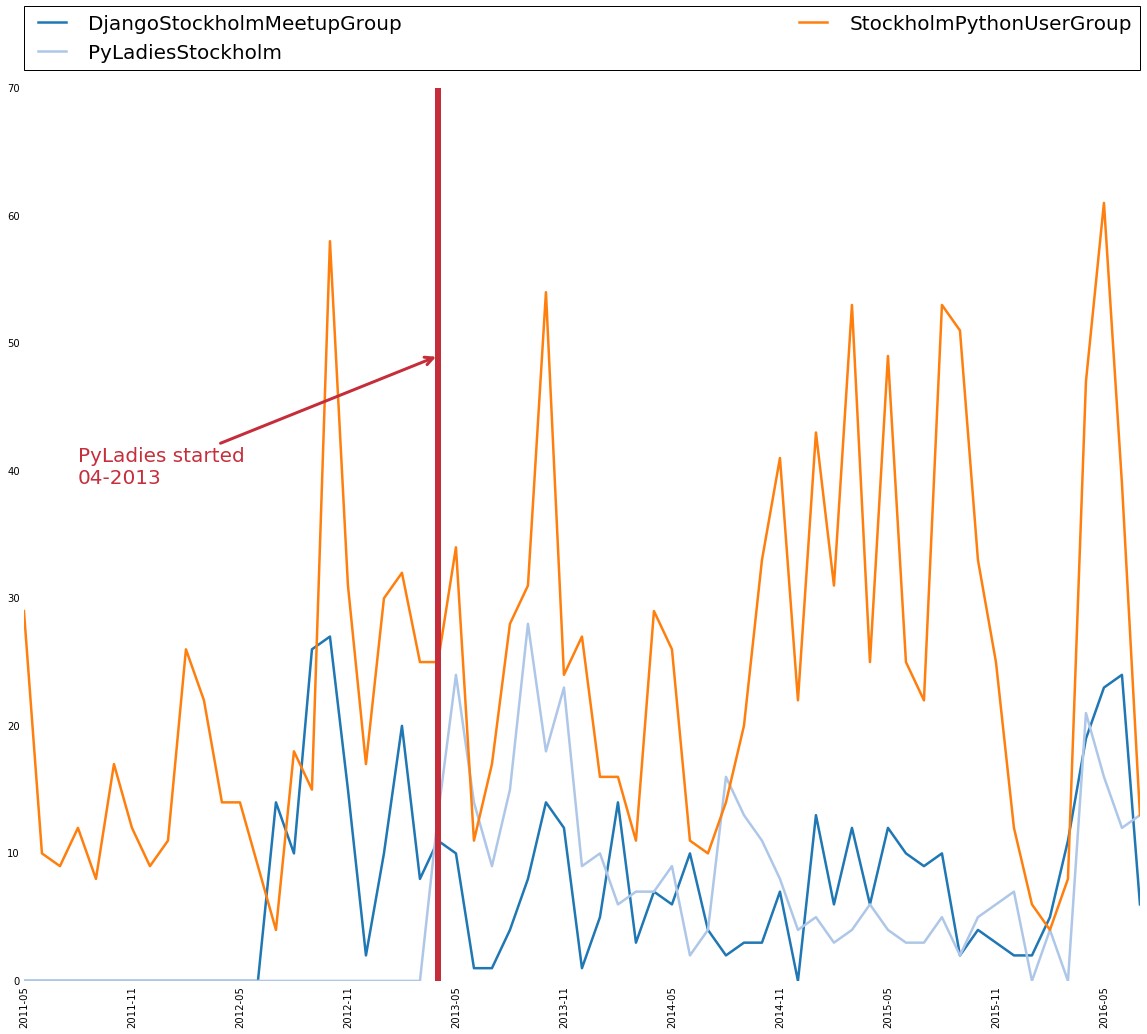

In [396]:
create_graph("PyLadiesStockholm")

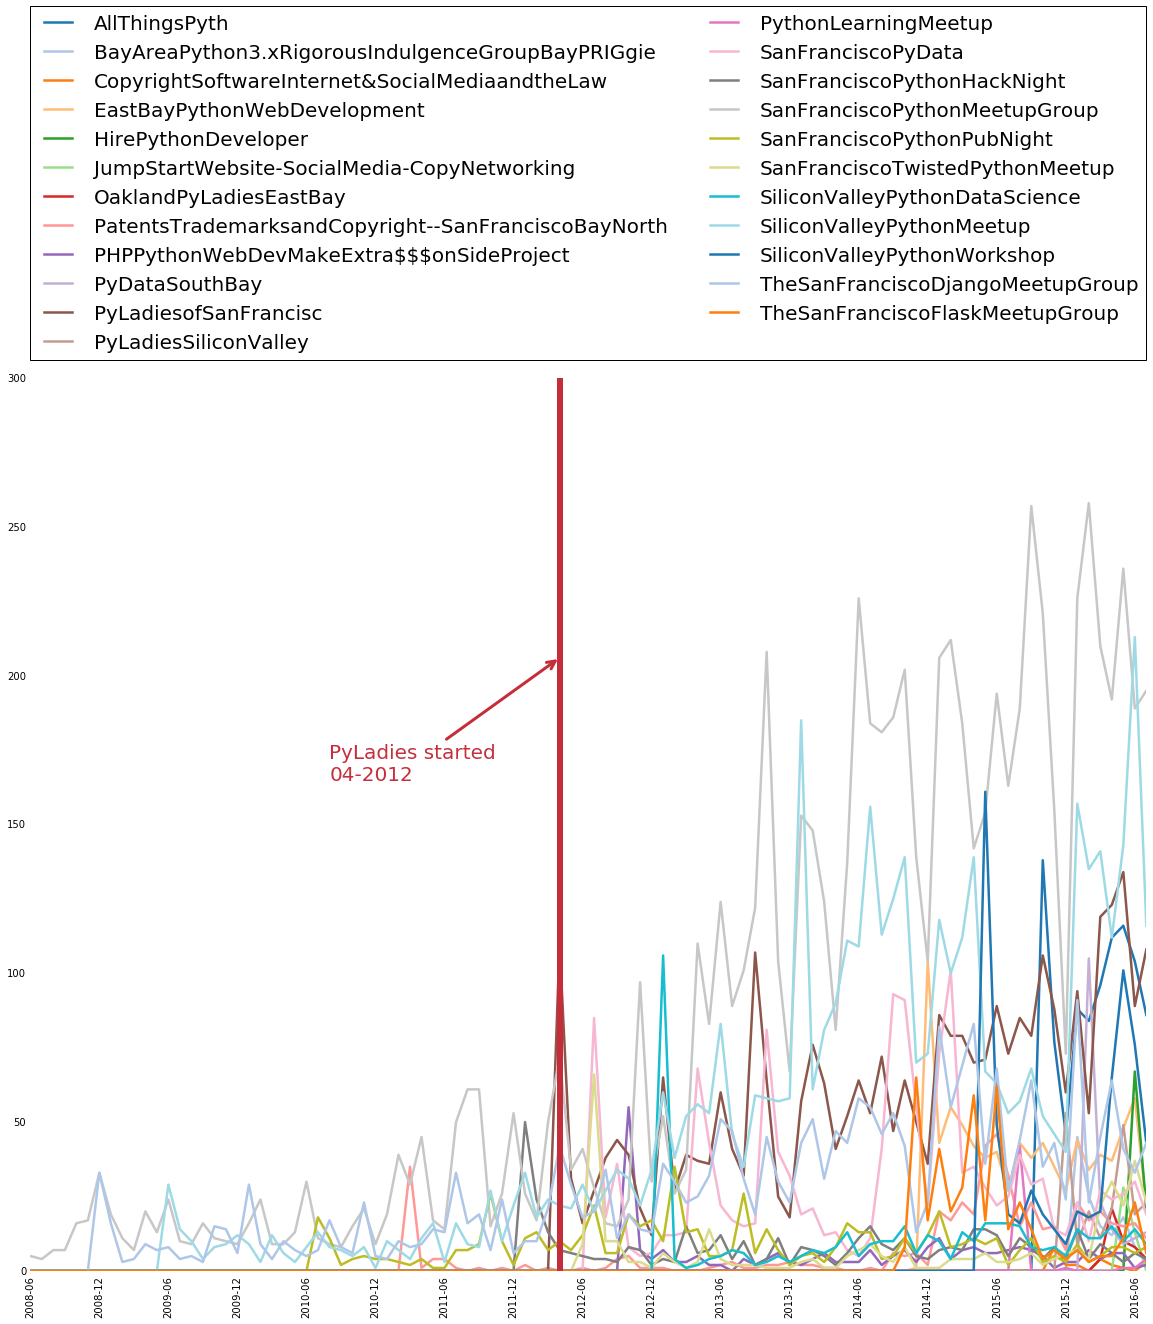

In [399]:
create_graph("PyLadiesofSanFrancisco")

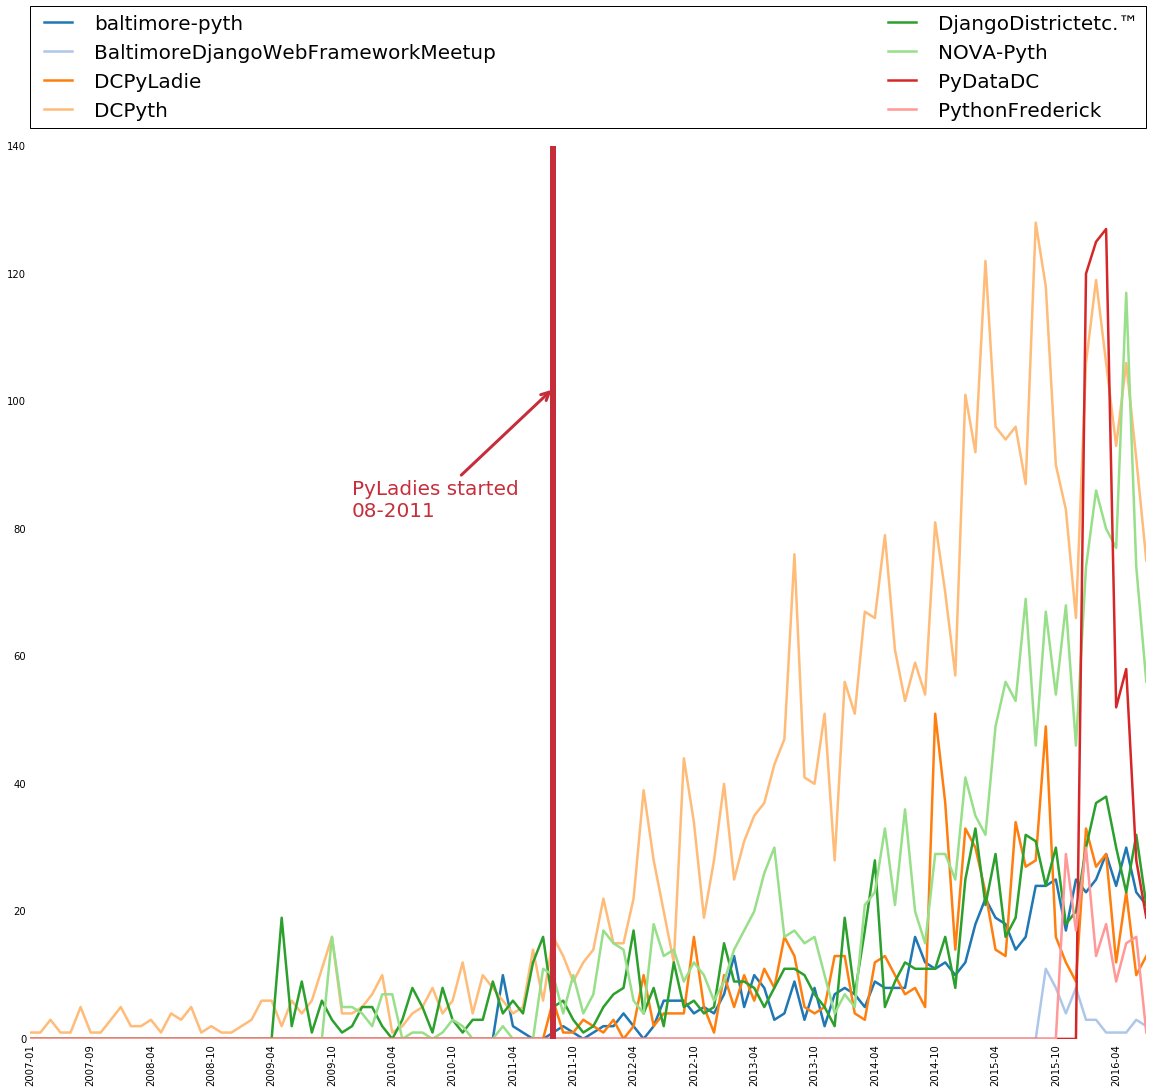

In [400]:
create_graph("DCPyLadies")

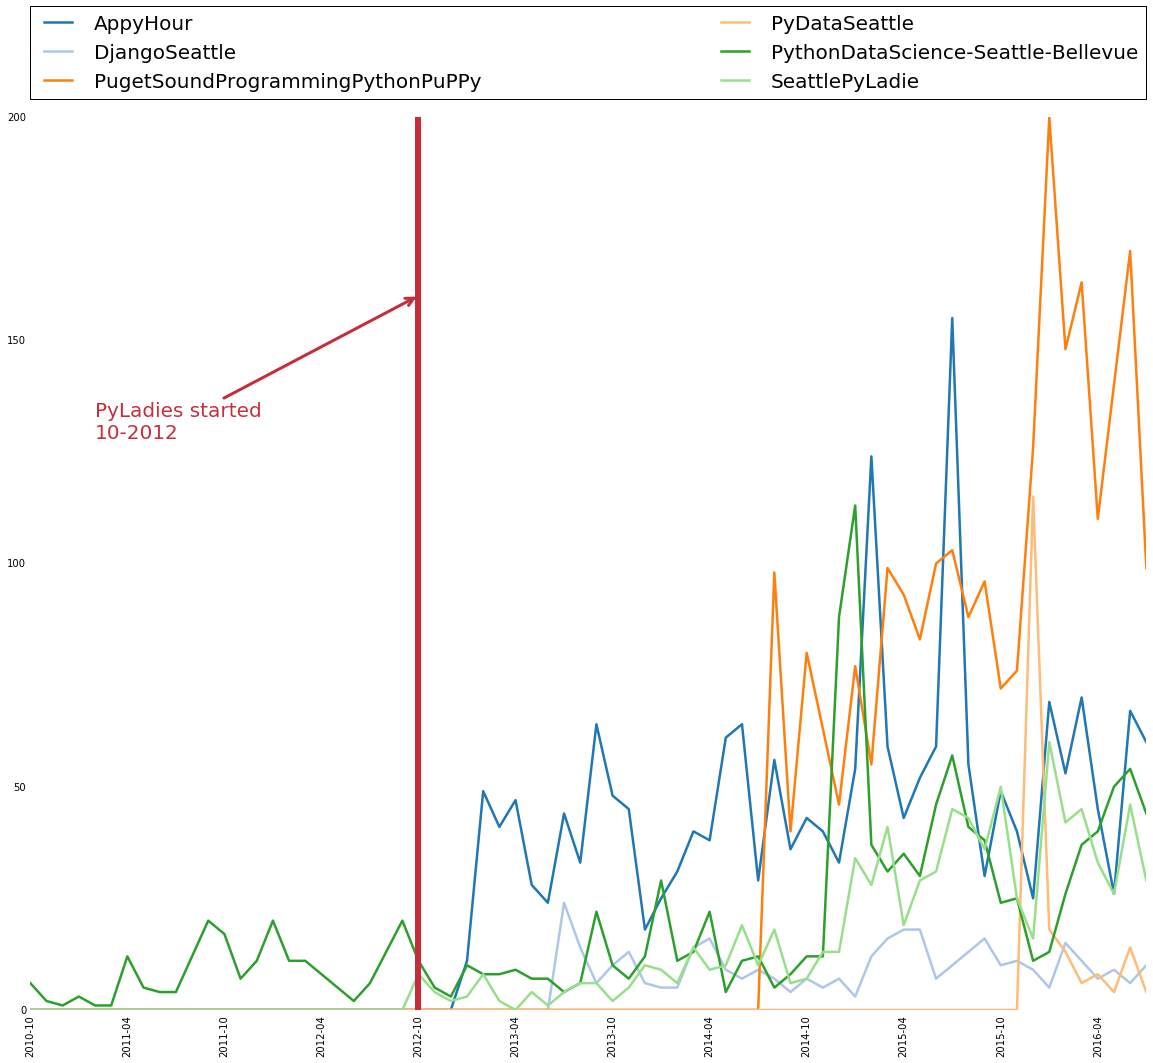

In [410]:
create_graph("SeattlePyLadies")